In [83]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science'])
mpl.rcParams["font.size"] = "12"

import torch
import torch.nn.init as init

from modules.utils import FeedForwardNetwork, plot_pde, plot_losses, rmse
from modules.problems import Diffusion

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [84]:
def train(
    problem,
    model,
    N_LB, N_RB, N_I, N_D,
    coef, lr, num_iters,
    print_every=1000, collect_every=1000
):
    x_sampled = torch.tensor(np.random.uniform(problem.L, problem.R, N_I), dtype=torch.float32)
    t_left_sampled =  torch.tensor(np.random.uniform(0, problem.T, N_LB), dtype=torch.float32)
    t_right_sampled = torch.tensor(np.random.uniform(0, problem.T, N_RB), dtype=torch.float32)
    
    def nearest_index(array, values):
            values = [np.abs(array - v).argmin().item() for v in values]
            return values
    
    problem.left_values =  problem.left_boundary [nearest_index(problem.t, t_left_sampled) ]
    problem.right_values = problem.right_boundary[nearest_index(problem.t, t_right_sampled)]
    problem.init_values =  problem.initial_values[nearest_index(problem.x, x_sampled)      ]

    x_pts = torch.tensor(np.random.uniform(problem.L, problem.R, N_D), requires_grad=True, dtype=torch.float32).reshape(-1, 1)
    t_pts = torch.tensor(np.random.uniform(0, problem.T, N_D), requires_grad=True, dtype=torch.float32).reshape(-1, 1)

    test_points = torch.cartesian_prod(problem.x, problem.t)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses, errors = [], []

    for i in range(num_iters + 1):

        optimizer.zero_grad()

        L_B, L_I = problem.loss_boundary(model, t_left_sampled, t_right_sampled, x_sampled)
        L_D = problem.loss_physical(model, x_pts, t_pts)

        total = coef * (L_B + L_I) + (1 - coef) * L_D

        total.backward()
        optimizer.step()
                
        if i % collect_every == 0:
            with torch.no_grad():
                preds = model(test_points).reshape(problem.Nx, problem.Nt).detach().numpy()
                error = rmse(preds.T, problem.solution)
                
                losses.append(np.array([L_I.item(), L_B.item(), L_D.item(), total.item()]))
                errors.append(error)
                
        if i % print_every == 0:
            print(f'Iteration {i} --- Loss {total.item()} --- RMSE {error}')
                
    return np.array(losses), np.array(errors)

In [ ]:
D = 0.5
L, R, T = 0, 1, 0.5
Nt, Nx = 500, 250
left_boundary = right_boundary = torch.zeros(Nt)
initial_conditions = torch.sin(2 * np.pi * torch.linspace(L, R, Nx)) ** 2

problem = Diffusion(
    D, (L, R, T), (Nt, Nx),
    (left_boundary, right_boundary, initial_conditions)
)

plot_pde(problem.x, problem.t, problem.solution, size=(6.5, 3))

In [ ]:
D = 0.1
L, R, T = -2, 2, 40
Nt, Nx = 500, 150
left_boundary = right_boundary = torch.zeros(Nt)
initial_conditions = torch.sin(0.5 * np.pi * torch.linspace(L, R, Nx)) ** 2

problem = Diffusion(
    D, (L, R, T), (Nt, Nx),
    (left_boundary, right_boundary, initial_conditions)
)

plot_pde(problem.x, problem.t, problem.solution, size=(6.5, 3))

In [ ]:
L, W = 2, 32
model = FeedForwardNetwork(L, W, input_dim=2, output_dim=1)
model.init_weights(init.kaiming_normal_)

N_I, N_LB, N_RB, N_D = 42, 12, 12, 1024
coef = 0.8
lr = 1e-3
num_iters = 2500
collect_every = 250

losses, errors = train(
    problem,
    model,
    N_LB, N_RB, N_I, N_D,
    coef=coef, lr=lr, num_iters=num_iters,
    collect_every=collect_every, print_every=500
)

In [ ]:
test_points = torch.cartesian_prod(problem.x, problem.t)
predictions = model(test_points).reshape(Nx, Nt).detach().numpy()
plot_pde(problem.x, problem.t, predictions.T, size=(6.5, 3))

In [ ]:
test_points = torch.cartesian_prod(problem.x, problem.t)
predictions = model(test_points).reshape(Nx, Nt).detach().numpy()
plot_pde(problem.x, problem.t, predictions.T - problem.solution, size=(6.5, 3))

In [ ]:
plot_pde(problem.x, problem.t, np.abs(predictions.T - problem.solution), size=(6.5, 3))

In [ ]:
plt.style.use(['grid'])

plot_losses(
    np.arange(0, num_iters+1, collect_every),
    losses=[
        (losses[:,0], r'$\mathcal{L_I}$'),
        (losses[:,1], r'$\mathcal{L_B}$'),
        (losses[:,2], r'$\mathcal{L_D}$'),
        (losses[:,3], r'$\mathcal{L_T}$')
    ],
    errors=[
        (errors, r'RMSE'),
    ]
)

## Interesting problem statements
---

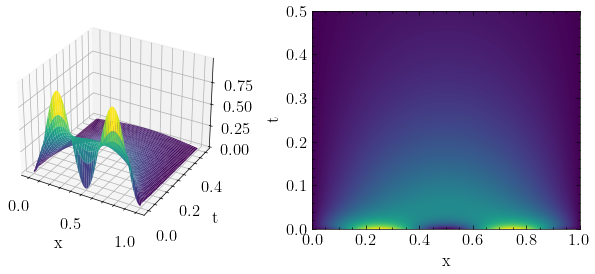

In [3]:
# Default

D = 0.5
L, R, T = 0, 1, 0.5
Nt, Nx = 500, 150
left_boundary = right_boundary = torch.zeros(Nt)
initial_conditions = torch.sin(2 * np.pi * torch.linspace(L, R, Nx)) ** 2

problem = Diffusion(
    D, (L, R, T), (Nt, Nx),
    (left_boundary, right_boundary, initial_conditions)
)

plot_pde(problem.x, problem.t, problem.solution, size=(6.5, 3))

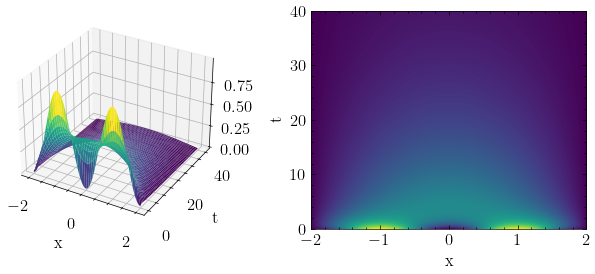

In [22]:
# Solution is visually indistinguishable from default, but parameters have changed.
# Will hyperparameters change too?

D = 0.1
L, R, T = -2, 2, 40
Nt, Nx = 500, 150
left_boundary = right_boundary = torch.zeros(Nt)
initial_conditions = torch.sin(0.5 * np.pi * torch.linspace(L, R, Nx)) ** 2

problem = Diffusion(
    D, (L, R, T), (Nt, Nx),
    (left_boundary, right_boundary, initial_conditions)
)

plot_pde(problem.x, problem.t, problem.solution, size=(6.5, 3))

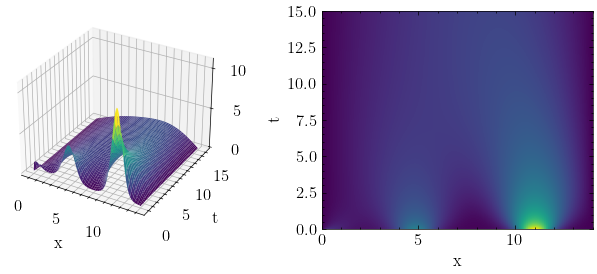

In [21]:
# Solution with two concentration peaks (plus one small on the left).

def f(x):
    return torch.exp(torch.sin(x)*torch.log(1/(x + np.finfo(float).eps)))

D = 0.4
L, R, T = 0, 14, 15
Nt, Nx = 500, 150
left_boundary = right_boundary = torch.zeros(Nt)
initial_conditions = f(torch.linspace(L, R, Nx))

problem = Diffusion(
    D, (L, R, T), (Nt, Nx),
    (left_boundary, right_boundary, initial_conditions)
)

plot_pde(problem.x, problem.t, problem.solution, size=(6.5, 3))

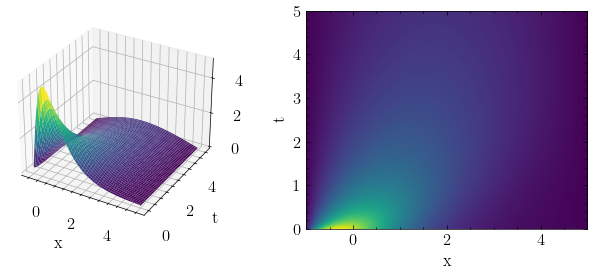

In [4]:
# Simple heat transfer with constant cold boundaries.

D = 0.7
L, R, T = -1, 5, 5
Nt, Nx = 500, 250
left_boundary = right_boundary = torch.zeros(Nt)
initial_conditions = torch.sin(torch.exp(-torch.linspace(L, R, Nx) + 0.145))*5

problem = Diffusion(
    D, (L, R, T), (Nt, Nx),
    (left_boundary, right_boundary, initial_conditions)
)

plot_pde(problem.x, problem.t, problem.solution, size=(6.5, 3))

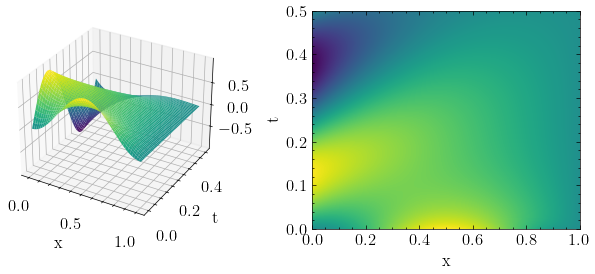

In [2]:
# Heat transfer with periodic boundary.

D = 0.5
L, R, T = 0, 1, 0.5
Nt, Nx = 500, 750
left_boundary = torch.sin(4 * torch.pi * torch.linspace(0, T, Nt))
right_boundary = torch.zeros(Nt)
initial_conditions = torch.sin(np.pi * torch.linspace(L, R, Nx)) ** 2

problem = Diffusion(
    D, (L, R, T), (Nt, Nx),
    (left_boundary, right_boundary, initial_conditions)
)

plot_pde(problem.x, problem.t, problem.solution, size=(6.5, 3))

In [35]:
def get_problem(N):
    match N:
        case 1:
            D = 0.5
            L, R, T = 0, 1, 0.5
            Nt, Nx = 500, 150
            left_boundary = right_boundary = torch.zeros(Nt)
            initial_conditions = torch.sin(2 * np.pi * torch.linspace(L, R, Nx)) ** 2
            
        case 2:
            D = 0.1
            L, R, T = -2, 2, 40
            Nt, Nx = 500, 150
            left_boundary = right_boundary = torch.zeros(Nt)
            initial_conditions = torch.sin(0.5 * np.pi * torch.linspace(L, R, Nx)) ** 2
            
        case 3:
            def f(x):
                return torch.exp(torch.sin(x)*torch.log(1/(x + np.finfo(float).eps)))
            D = 0.4
            L, R, T = 0, 14, 15
            Nt, Nx = 500, 150
            left_boundary = right_boundary = torch.zeros(Nt)
            initial_conditions = f(torch.linspace(L, R, Nx))
            
        case 4:
            D = 0.7
            L, R, T = -1, 5, 5
            Nt, Nx = 500, 250
            left_boundary = right_boundary = torch.zeros(Nt)
            initial_conditions = torch.sin(torch.exp(-torch.linspace(L, R, Nx) + 0.145))*5
            
        case 5:
            D = 0.5
            L, R, T = 0, 1, 0.5
            Nt, Nx = 500, 750
            left_boundary = torch.sin(4 * torch.pi * torch.linspace(0, T, Nt))
            right_boundary = torch.zeros(Nt)
            initial_conditions = torch.sin(np.pi * torch.linspace(L, R, Nx)) ** 2
            
    problem = Diffusion(
        D, (L, R, T), (Nt, Nx),
        (left_boundary, right_boundary, initial_conditions)
    )
    return problem

## Hyperparameters tuning
---

In [183]:
import optuna

best_model = None
model = None

def get_pts(problem, N_I, N_LB, N_RB, N_D, sampling):
    if sampling == 'random':
        x_sampled = torch.tensor(np.random.uniform(problem.L, problem.R, N_I), dtype=torch. float32, requires_grad=True)
        t_left_sampled =  torch.tensor(np.random.uniform(0, problem.T, N_LB), dtype=torch.float32, requires_grad=True)
        t_right_sampled = torch.tensor(np.random.uniform(0, problem.T, N_RB), dtype=torch.float32, requires_grad=True)
        
        x_pts = torch.tensor(np.random.uniform(problem.L, problem.R, N_D), requires_grad=True, dtype=torch.float32).reshape(-1, 1)
        t_pts = torch.tensor(np.random.uniform(0, problem.T, N_D), requires_grad=True, dtype=torch.float32).reshape(-1, 1)
        
    else:
        x_sampled = torch.linspace(problem.L, problem.R, N_I, requires_grad=True)
        t_left_sampled =  torch.linspace(0, problem.T, N_LB, requires_grad=True)
        t_right_sampled = torch.linspace(0, problem.T, N_RB, requires_grad=True)
        
        k = np.sqrt(problem.Nt * problem.Nx / N_D)
        nt, nx = int(problem.Nt / k), int(problem.Nx / k)
        x_pts, t_pts = [
            pts.reshape(-1, 1) for pts in torch.meshgrid(
            torch.linspace(problem.L, problem.R, nx, requires_grad=True),
            torch.linspace(0, problem.T, nt, requires_grad=True),
            indexing='ij'
        )]
    
    def nearest_index(array, values):
            values = [np.abs(array - v).argmin().item() for v in values.detach().numpy()]
            return values
    
    problem.left_values =  problem.left_boundary [nearest_index(problem.t, t_left_sampled) ]
    problem.right_values = problem.right_boundary[nearest_index(problem.t, t_right_sampled)]
    problem.init_values =  problem.initial_values[nearest_index(problem.x, x_sampled)      ]

    return x_sampled, t_left_sampled, t_right_sampled, x_pts, t_pts

def objective(trial):
    
    global model
    
    L = trial.suggest_int('L', 2, 8, step=2)
    W = trial.suggest_int('W', 32, 64, step=16)
    model = FeedForwardNetwork(L, W, input_dim=2, output_dim=1).to(device)
    
    init_rule = trial.suggest_categorical(
        'initialization', 
        ['default', 'eye', 'normal', 'xavier', 'kaiming', 'orthogonal']
    )
    if init_rule == 'eye':
        model.init_weights(init.eye_)
    elif init_rule == 'normal': 
        model.init_weights(init.normal_)
    elif init_rule == 'xavier':
        model.init_weights(init.xavier_normal_)
    elif init_rule == 'kaiming':
        model.init_weights(init.kaiming_normal_)
    elif init_rule == 'orthogonal':
        model.init_weights(init.orthogonal_)
    
    N_I = trial.suggest_int('N_I', 24, problem.Nx // 2)
    N_LB = trial.suggest_int('N_LB', 12, problem.Nt // 2)
    N_RB = trial.suggest_int('N_RB', 12, problem.Nt // 2)
    N_D = trial.suggest_int('N_D', 128, 1024*5, log=True)
    sampling = trial.suggest_categorical('sampling', ['random', 'grid'])
    
    while True:
        try:
            x_sampled, t_left_sampled, t_right_sampled, x_pts, t_pts = get_pts(
                problem, N_I, N_LB, N_RB, N_D, sampling
            )
        except:
            print('Error in generating points... Trying again...')
        else:
            break
    
    coef = trial.suggest_float('coef', 0.05, 0.95)
    
    lr = trial.suggest_float('lr', 1e-5, 1.0, log=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    test_points = torch.cartesian_prod(problem.x, problem.t)
    preds = model(test_points).reshape(problem.Nx, problem.Nt).detach().numpy()
    error = rmse(preds.T, problem.solution)

    for i in range(5000):

        optimizer.zero_grad()

        L_B, L_I = problem.loss_boundary(model, t_left_sampled, t_right_sampled, x_sampled)
        L_D = problem.loss_physical(model, x_pts, t_pts)

        total = coef * (L_B + L_I) + (1 - coef) * L_D

        total.backward()
        optimizer.step()
        
        if (i + 1) % 500 == 0:
            with torch.no_grad():
                preds = model(test_points).reshape(problem.Nx, problem.Nt).detach().numpy()
                error = rmse(preds.T, problem.solution)
            
            trial.report(error, i + 1)
            
            if trial.should_prune():
                raise optuna.TrialPruned()
        
    return error

def callback(study, trial):
    global best_model
    
    if study.best_trial == trial:
        best_model = model

In [ ]:
problem_number = 1
problem = get_problem(problem_number)

study = optuna.create_study(study_name=f'diff_{problem_number}', direction='minimize', 
                            sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.SuccessiveHalvingPruner())

study.optimize(objective, n_trials=25, callbacks=[callback])
study.trials_dataframe().to_csv(f'./studies/{study.study_name}.csv', sep=',')
    
torch.save(best_model, f'./studies/{study.study_name}_best_model.pt')

In [ ]:
test_model = torch.load('./studies/diff_1_best_model.pt')
test_points = torch.cartesian_prod(problem.x, problem.t)
preds = model(test_points).reshape(problem.Nx, problem.Nt).detach().numpy()
plot_pde(problem.x, problem.t, preds.T, size=(6.5, 3))

## Hyperparameters analysis
---

In [120]:
import pandas as pd
from modules.utils import get_corr, plot_rmse_corr

In [123]:
new_names = ['rmse', 'L', 'N_D', 'N_I', 'N_LB', 'N_RB', 'W', 'coef', 'init', 'lr', 'sampling', 'iters']

diff1 = pd.read_csv('./studies/diff_1.csv', index_col=0).drop(['number', 'datetime_start', 'datetime_complete', 'duration', 'state'], axis=1)
diff2 = pd.read_csv('./studies/diff_2.csv', index_col=0).drop(['number', 'datetime_start', 'datetime_complete', 'duration', 'state'], axis=1)
# lv3 = pd.read_csv('./studies/lv_3.csv', index_col=0).drop(['number', 'datetime_start', 'datetime_complete', 'duration', 'state'], axis=1)
# lv4 = pd.read_csv('./studies/lv_4.csv', index_col=0).drop(['number', 'datetime_start', 'datetime_complete', 'duration', 'state'], axis=1)

for df in [diff1, diff2]:
    df.columns = new_names

Instances of group...
default - 2
eye - 2
kaiming - 10
orthogonal - 6
xavier - 2


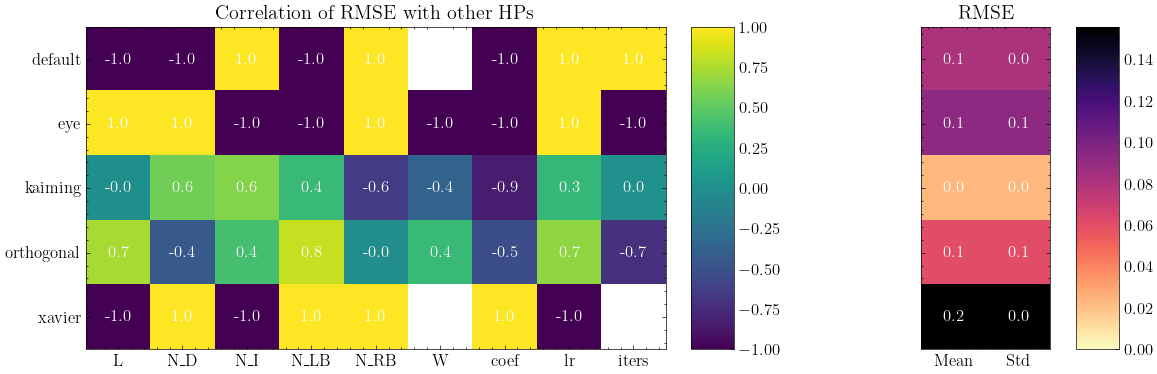

In [147]:
correlation, rmse_data, xlabels, ylabels = get_corr(diff1.drop(['sampling'], axis=1))
plot_rmse_corr(correlation, rmse_data, xlabels, ylabels, k=0.5)